# SIS 1 Correlation Analysis of Teres Major and Minor

This Python script performs an analysis to determine the correlation between the log-transformed 
origin areas and volumes of specific shoulder muscles. The analysis is conducted for the following 
muscles:
- Teres Major
- Teres Minor

The log-transformation is applied to the origin areas and volumes to normalize the data and improve
the accuracy of the correlation analysis.

## Imports

Required packages for this analysis can be found in the `requirements.txt` file. Ensure that all dependencies are installed before running the script.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import os
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# ANSI escape code for bold text in print
bold_start = "\033[1m"
bold_end = "\033[0m"

## Input Setup

Loads the `Muscle_data.xlsx` file containing all original data and removes specimens where 3D reconstructions have not been performed.rt os

In [2]:
# Construct the relative path to the data file
file_path = os.path.join('Muscle_data.xlsx')

# Load the data from the Excel file
data = pd.read_excel(file_path)

# Apply logarithmic transformation to the Origin_Area and Muscle_Volume_rec
data['Log_Origin_Area'] = np.log(data['Origin_Area (cm²)'])
data['Log_Volume_rec'] = np.log(data['Volume_rec (cm³)'])
data['Log_Volume_exp'] = np.log(data['Volume_exp (cm³)'])

## Filter data

Remove Supraspinatus, Infraspinatus and Subscapularis from the analysis to investigate them separately.

In [3]:
# Filter data and store in values
filtered_dataTeres = data[~data['Muscle_Name'].isin(['Supraspinatus', 'Infraspinatus', 'Subscapularis'])]
# Step 2: Remove rows with missing values in the columns 'Origin_Area (cm²)' and 'Volume_exp (cm³)'
filtered_dataTeres = filtered_dataTeres.dropna(subset=['Origin_Area (cm²)', 'Volume_exp (cm³)'])

# store transformed variables
muscle_originTeres = filtered_dataTeres['Log_Origin_Area']
muscle_volumeTeres = filtered_dataTeres['Log_Volume_exp']

## Tests for normality

Performs a Shapiro-Wilk test and evaluates normality using Q-Q plots

Shapiro-Wilk test for data1:  ShapiroResult(statistic=0.9764683665986374, pvalue=0.9183015896483309)
Shapiro-Wilk test for data2:  ShapiroResult(statistic=0.9379240782979819, pvalue=0.2943891441958709)


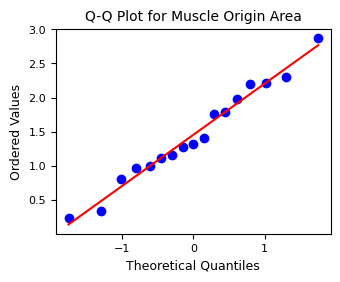

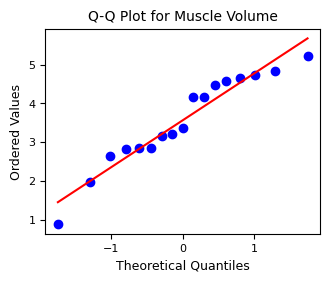

In [4]:
# Shapiro-Wilk test for normality
shapiro_test1Teres = stats.shapiro(muscle_originTeres)
shapiro_test2Teres = stats.shapiro(muscle_volumeTeres)

print("Shapiro-Wilk test for data1: ", shapiro_test1Teres)
print("Shapiro-Wilk test for data2: ", shapiro_test2Teres)

# Set figure size (convert cm to inches)
width_cm = 9
height_cm = width_cm * 0.75  # Aspect ratio of 4:3 (optional)
width_in = width_cm / 2.54
height_in = height_cm / 2.54

# Q-Q plot for data1
# Create figure with specified size
plt.figure(figsize=(width_in, height_in))
stats.probplot(muscle_originTeres, dist="norm", plot=plt)
plt.title("Q-Q Plot for Muscle Origin Area", fontsize=10)
plt.xlabel("Theoretical Quantiles", fontsize=9)  # Set xlabel font
plt.ylabel("Ordered Values", fontsize=9)  # Set ylabel font
# Apply custom font to tick labels
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
# Show Figure
plt.show()

# Q-Q plot for data2
plt.figure(figsize=(width_in, height_in))
stats.probplot(muscle_volumeTeres, dist="norm", plot=plt)
plt.title("Q-Q Plot for Muscle Volume", fontsize=10)
plt.xlabel("Theoretical Quantiles", fontsize=9)  # Set xlabel font
plt.ylabel("Ordered Values", fontsize=9)  # Set ylabel font
# Apply custom font to tick labels
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.show()

## Pearson Correlation Analysis

In [5]:
# Correlation analysis for Teres major and minor

r, p = stats.pearsonr(muscle_originTeres, muscle_volumeTeres)
# Calculate degrees of freedom
n = len(muscle_originTeres)
df = n - 2


# Calculate confidence interval for Pearson correlation coefficient
alpha = 0.05  # significance level for 95% confidence interval
z = np.arctanh(r)
SE_z = 1 / np.sqrt(n - 3)
z_critical = stats.norm.ppf(1 - alpha / 2)
z_lower = z - z_critical * SE_z
z_upper = z + z_critical * SE_z
r_lower = np.tanh(z_lower)
r_upper = np.tanh(z_upper)

# Create p_tex value
if p < 0.001:
    p_tex = "<0.001"
elif p < 0.05:
    p_tex = "<0.05"
else:
    p_tex = ">0.05"
    

# Calculate the linear regression
x = filtered_dataTeres['Log_Origin_Area']
y = filtered_dataTeres['Log_Volume_exp']
X = sm.add_constant(x) # add column for intercept
re = sm.OLS(y, X).fit()
# print the summary of the linear regression
print(re.summary())



                            OLS Regression Results                            
Dep. Variable:         Log_Volume_exp   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     11.36
Date:                Wed, 23 Oct 2024   Prob (F-statistic):            0.00421
Time:                        17:40:39   Log-Likelihood:                -21.520
No. Observations:                  17   AIC:                             47.04
Df Residuals:                      15   BIC:                             48.71
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.9960      0.516     

C:\ProgramData\anaconda3\envs\env_MuscVolReco\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  res = hypotest_fun_out(*samples, **kwds)



The Pearson correlation coefficient was found to be r = 0.66, p = 4.21e-03, 
with degrees of freedom df = 15 (n = 17).

95% Confidence interval for r: (0.26, 0.86)

The Regression line equation is: y = 1.08x + 2.00.



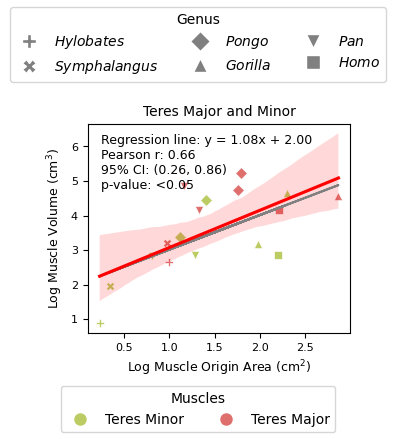

In [6]:
# determine results
# determine prediction intervals boundaries
prstd, iv_l, iv_u = wls_prediction_std(re)
# determine slope and intercept
intercept = re.params.iloc[0] # The first parameter is the intercept
slope = re.params.iloc[1]      # The remaining parameters are the slope(s)

# determine y values for linear model
y_pred = slope * x + intercept

# Format the regression line equation
if intercept < 0:
    regression_eq = f'y = {slope:.2f}x - {abs(intercept):.2f}'
else:
    regression_eq = f'y = {slope:.2f}x + {intercept:.2f}'

# Reporting
print(f"\nThe Pearson correlation coefficient was found to be {bold_start}r = {r:.2f}{bold_end}, p = {p:.2e}, \nwith degrees of freedom df = {df} (n = {n}).\n")

print(f"95% Confidence interval for r: ({r_lower:.2f}, {r_upper:.2f})\n")
print(f"The Regression line equation is: {bold_start}{regression_eq}{bold_end}.\n")



# Figure settings Correlation Teres

# Define the custom colors for each muscle
custom_colors = {    
    'Teres Minor': (0.741, 0.8, 0.384),
    'Teres Major': (0.871, 0.435, 0.427)
}

# Define unique markers for specimen
custom_markers = {
    'Hylobates': 'P',
    'Symphalangus': 'X',
    'Pongo': 'D',
    'Gorilla': '^',
    'Pan': 'v',
    'Homo': 's'
}

# Get unique muscle names and specimen names
muscle_names = filtered_dataTeres['Muscle_Name']
specimen_names = filtered_dataTeres['Genus']

# Set figure size (convert cm to inches)
width_cm = 8.5
height_cm = 11
width_in = width_cm / 2.54
height_in = height_cm / 2.54

# Create the figure and subplots
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(width_in, height_in))

# Determine line for isometric scaling
Y = filtered_dataTeres['Log_Origin_Area'] + slope*min(filtered_dataTeres['Log_Origin_Area']) + intercept -min(filtered_dataTeres['Log_Origin_Area'])
ax1.plot(filtered_dataTeres['Log_Origin_Area'], Y, color='grey')

# Plot each data point with the respective color and marker
for muscle, color in custom_colors.items():
    for specimen, marker in custom_markers.items():
        mask = (muscle_names == muscle) & (specimen_names == specimen)
        sns.scatterplot(x='Log_Origin_Area', y='Log_Volume_exp', data=filtered_dataTeres[mask], ax=ax1,
                        color=color, marker=marker)

# Add regression line and confidence interval
sns.regplot(x='Log_Origin_Area', y='Log_Volume_exp', data=filtered_dataTeres, ax=ax1, scatter=False, color='red')

# Apply custom fonts to the plot
ax1.set_title('Teres Major and Minor', fontsize=10)
ax1.set_xlabel('Log Muscle Origin Area (cm$^2$)', fontsize=9)
ax1.set_ylabel('Log Muscle Volume (cm$^3$)', fontsize=9)

ax1.tick_params(axis='both', which='major', labelsize=8)
for label in ax1.get_xticklabels() :
    label.set_size(8)
    
ax1.annotate(
    f'Regression line: {regression_eq}\nPearson r: {r:.2f}\n95% CI: ({r_lower:.2f}, {r_upper:.2f})\np-value: {p_tex}', 
    xy=(0.05, 0.95), xycoords='axes fraction', fontsize=9, 
    horizontalalignment='left', verticalalignment='top'
)


# Create custom legend handles
handles_muscles = [plt.Line2D([0], [0], marker='o', color='w', label=muscle,
                              markerfacecolor=color, markersize=10) 
                   for muscle, color in custom_colors.items()]

# Create handles with italicized labels
handles_specimen = [
    plt.Line2D(
        [0], [0],
        marker=marker,
        color='w',
        label=f'${specimen}$',  # Italicize the label here
        markerfacecolor='gray',
        markersize=10
    )
    for specimen, marker in custom_markers.items()
]

# Add legends above and below the plots
fig.legend(handles=handles_specimen, title='Genus', loc='upper center', ncol=3)
fig.legend(handles=handles_muscles, title='Muscles', loc='lower center', ncol=6)

# Adjust layout to make room for legends
plt.tight_layout(rect=[0, 0.1, 1, 0.8])  # Leave space for legends

plt.show()